In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('final_df.csv')
df.head()

,OwnCar,OwnProperty,ChildrenCount,TotalIncome,IncomeType,EducationType,FamilyStatus,HousingType,FamilyMembers,Target,AccountLength,Age,Unemployed,YearsEmployed
0,1,1,0,427500.0,3.0,3.0,3.0,3.0,2,1,15,32.868596,0,12.435582
1,1,1,0,112500.0,3.0,1.0,4.0,5.0,2,0,29,58.793855,0,3.104789
2,0,1,0,270000.0,2.0,1.0,0.0,5.0,1,0,4,52.321439,0,8.353360
3,0,1,0,283500.0,1.0,3.0,1.0,5.0,1,0,20,61.504385,1,0.000000
4,1,1,0,270000.0,3.0,3.0,4.0,5.0,2,0,5,46.193999,0,2.105452


In [2]:
df.isna().sum()

OwnCar           0
OwnProperty      0
ChildrenCount    0
TotalIncome      0
IncomeType       0
EducationType    0
FamilyStatus     0
HousingType      0
FamilyMembers    0
Target           0
AccountLength    0
Age              0
Unemployed       0
YearsEmployed    0
dtype: int64

The preprocessed dataset has no NA values
Let me check correlation matrix

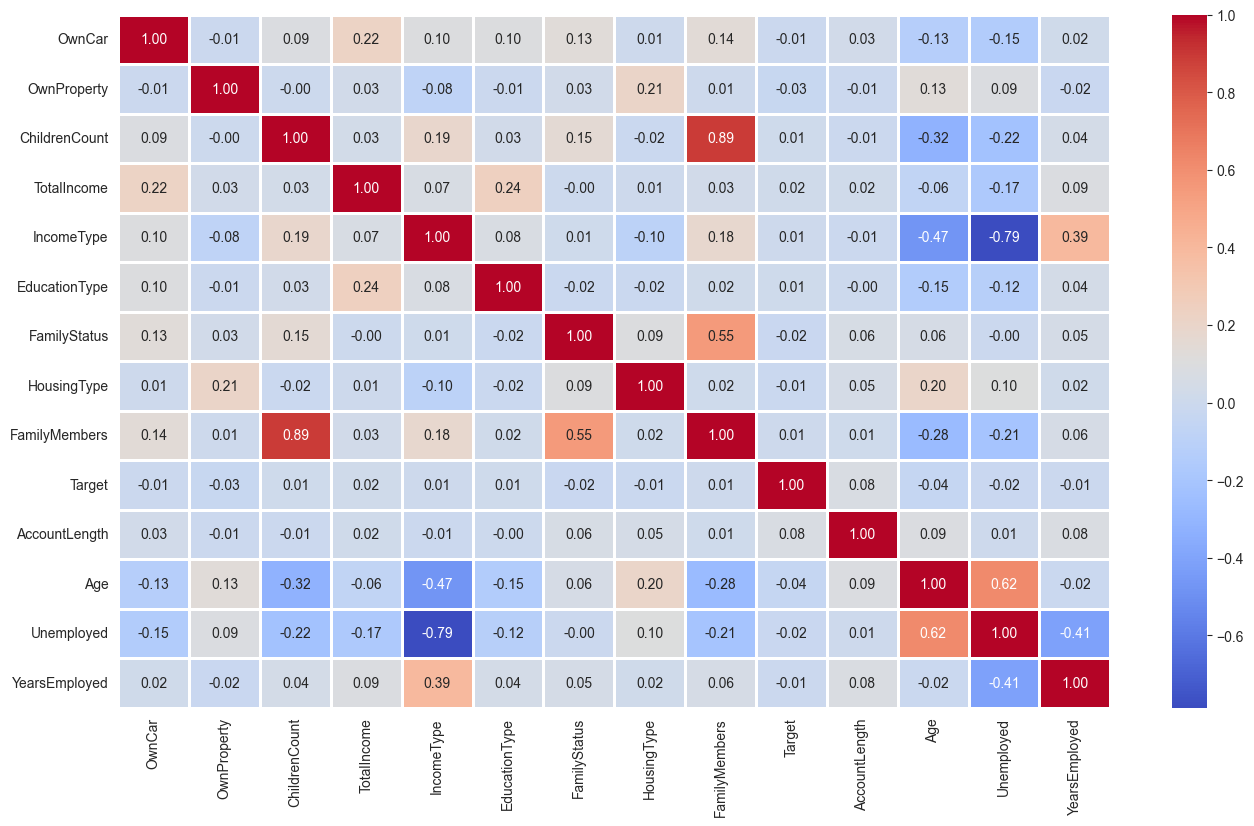

In [3]:
plt.figure(figsize=(16, 9))
sns.heatmap(data=df.corr(), annot=True, linewidths=1, fmt='.2f', cmap='coolwarm')
plt.show()

__let me check class imbalance__

<Axes: xlabel='Target', ylabel='count'>

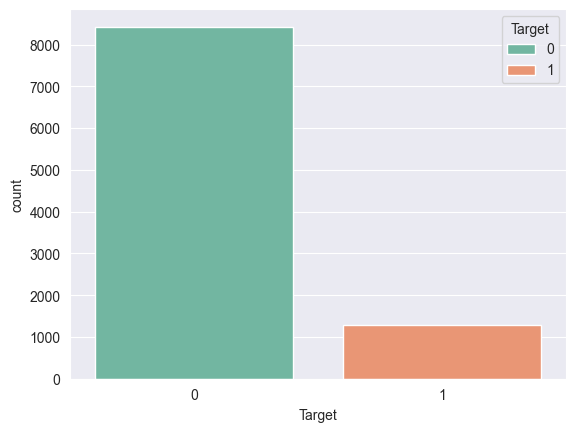

In [4]:
sns.countplot(x='Target', data=df, hue='Target', palette='Set2')

There is class imbalance so that SMOTE or any other possible techniques have to be used to balance the classes. 
Let's do this after splitting the dataset into train and test sets to avoid data leakage.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Target'], axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6796, 13), (2913, 13), (6796,), (2913,))

In [6]:
import os
os.cpu_count()//2

6

In [7]:
y_train.value_counts()

Target
0    5898
1     898
Name: count, dtype: int64

In [8]:
from sklearn.pipeline import Pipeline as SciPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

sampling_strategy = {
    0: 20000,
    1: 20000,
}

continuous_features = ['TotalIncome', 'Age', 'YearsEmployed']

scaling_transformer = SciPipeline([
    ('scaler', MinMaxScaler(feature_range=(0, 1))),
])

preprocessor = ColumnTransformer(transformers=[
    ('scaling_transformer', scaling_transformer, continuous_features),
], remainder='passthrough', force_int_remainder_cols=False)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('over', SMOTE(random_state=69, sampling_strategy=sampling_strategy)),
    ('classifier', RandomForestClassifier(n_jobs=6, random_state=69)),
])


param_grid = [
    {
        'classifier': [RandomForestClassifier(n_jobs=6, random_state=69)],
        'classifier__n_estimators': [50, 100],  # Added Random Forest classifier
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [XGBClassifier(n_jobs=6)],
        'classifier__max_depth': [3, 6, 9],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.1, 0.01, 0.001],
    },
    {
        'classifier': [LGBMClassifier(n_jobs=6)],
        'classifier__num_leaves': [25, 50, 75],
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.1, 0.01, 0.001],
    },
]

In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

kf = StratifiedKFold(n_splits=5, random_state=69, shuffle=True)

grid_search = GridSearchCV(pipeline, param_grid, scoring='f1', cv=kf, n_jobs=6, verbose=3)
grid_search.fit(X_train, y_train.values)

print("Best parameters found: ", grid_search.best_params_)
grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=6,
              num_parallel_tree=None, random_state=None, ...), 'classifier__learning_rate': 0.001, 'classifier__max_depth': 9, 'classifier__n_estimators': 50}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaling_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['TotalIncome', 'Age',
                                                   'YearsEmployed'])])),
                ('over',
                 SMOTE(random_state=69,
                       sampling_strategy={0: 20000, 1: 20000})),
                ('classifier',
                 XGBClassifier(base_score=None, booster=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.001, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=9,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=50, n_jobs=6,
                               num_parallel_tree=None, random_state=None, ...))])

In [10]:
import json
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(json.dumps(classification_report(y_test, y_pred, zero_division=1, output_dict=True), indent=4))

{
    "0": {
        "precision": 0.8738354037267081,
        "recall": 0.8904272151898734,
        "f1-score": 0.8820532915360502,
        "support": 2528.0
    },
    "1": {
        "precision": 0.17804154302670624,
        "recall": 0.15584415584415584,
        "f1-score": 0.16620498614958448,
        "support": 385.0
    },
    "accuracy": 0.7933401991074494,
    "macro avg": {
        "precision": 0.5259384733767072,
        "recall": 0.5231356855170146,
        "f1-score": 0.5241291388428173,
        "support": 2913.0
    },
    "weighted avg": {
        "precision": 0.7818750067581186,
        "recall": 0.7933401991074494,
        "f1-score": 0.7874423757880964,
        "support": 2913.0
    }
}


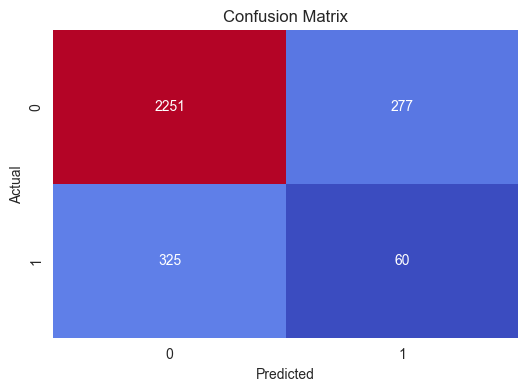

In [11]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

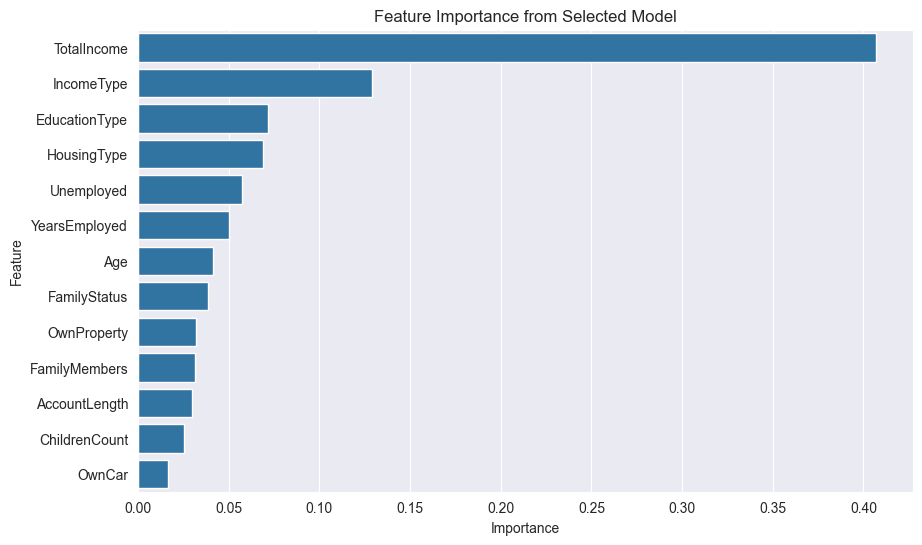

In [12]:
import numpy as np

best_model = grid_search.best_estimator_.named_steps['classifier']

if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    feature_importance = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]
    sns.barplot(x=feature_importance[sorted_idx], y=np.array(X.columns)[sorted_idx])
    plt.title("Feature Importance from Selected Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The selected model does not support feature importances.")

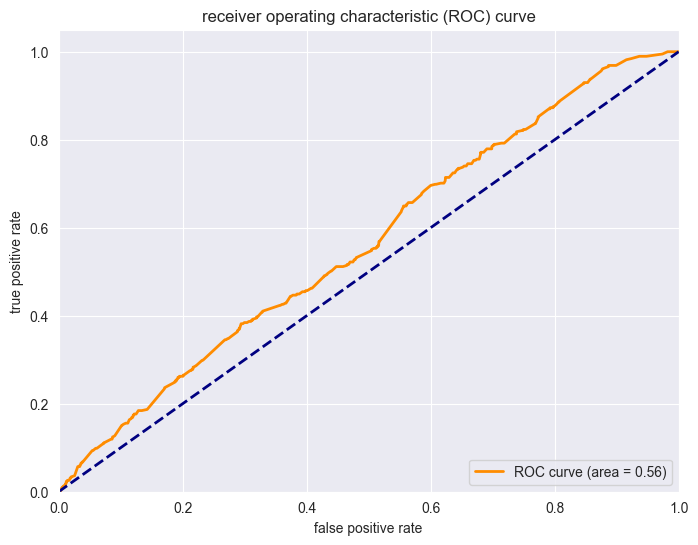

In [13]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()